In [1]:
import os
import shutil

import numpy as np
import tensorflow as tf

2023-03-19 09:42:18.709873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 09:42:19.969922: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import tensorflow as tf
import random
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  4


In [3]:
os.getcwd()

'/home/yang'

In [4]:
os.chdir('Train')
os.getcwd()

'/home/yang/Train'

In [5]:
!find . -name ".ipynb_checkpoints" -print -delete
!find . -name ".DS_Store" -print -delete

In [6]:
import pandas as pd

# Load the CSV file into a pandas dataframe
df = pd.read_csv('/home/yang/CVPR/data_info.csv')

# Display the first few rows of the dataframe
print(df.head())

   File_ID  Split  Adoration  Amusement   Anxiety   Disgust  Empathic-Pain  \
0  [00000]  Train   0.000000   0.039090  1.000000  0.106748       0.142947   
1  [00001]  Train   0.051464   0.224765  1.000000  0.221065       0.159005   
2  [00002]  Train   0.082981   1.000000  0.208966  0.223763       0.042512   
3  [00003]  Train   0.330907   1.000000  0.640425  0.279108       0.092854   
4  [00004]  Train   0.031124   0.055308  0.958352  0.161568       0.112866   

       Fear  Surprise   Age        Country  
0  0.633131  0.306611  23.0  United States  
1  0.311960  0.371110  27.0   South Africa  
2  0.102279  0.729082  44.0  United States  
3  0.000000  0.558488  39.0  United States  
4  1.000000  0.366121  22.5  United States  


In [7]:
df.size

275737

In [8]:
dataset = np.load('/home/yang/CVPR/dataset.npy')

print(dataset.shape)

(1000, 32, 224, 224, 3)


In [9]:
import numpy as np

# Assuming your dataset is a NumPy array or a TensorFlow tensor named 'dataset'
num_bytes = dataset.nbytes if isinstance(dataset, np.ndarray) else dataset.numpy().nbytes
size_in_gb = num_bytes / (1024 ** 3)  # Convert bytes to gigabytes

size_in_gb


4.486083984375

In [10]:
dataset.dtype

dtype('uint8')

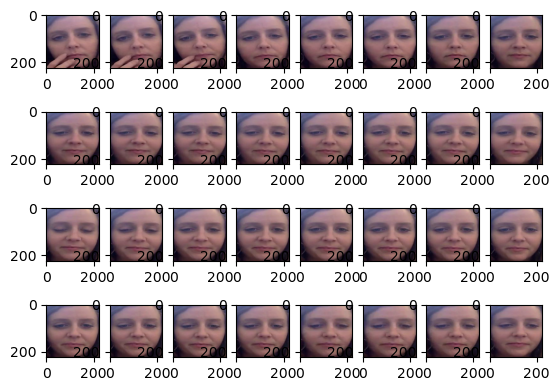

In [11]:
import matplotlib.pyplot as plt

# Display images from the first chunk
fig, axs = plt.subplots(4, 8)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(dataset[319, i])
plt.show()


In [9]:
import numpy as np

# Assuming your dataset is a NumPy array or a TensorFlow tensor named 'dataset'
if not isinstance(dataset, np.ndarray):
    dataset = dataset.numpy()  # Convert TensorFlow tensor to NumPy array if needed

# Ensure dataset is in float32 format
dataset = dataset.astype(np.float32)

# Reshape the dataset to have 2 dimensions: samples and features
num_samples = dataset.shape[0] * dataset.shape[1]
num_features = dataset.shape[2] * dataset.shape[3] * dataset.shape[4]
reshaped_dataset = dataset.reshape(num_samples, num_features)

# Normalize the dataset
mean = np.mean(reshaped_dataset, axis=0).astype(np.float32)
std = np.std(reshaped_dataset, axis=0).astype(np.float32)
normalized_dataset = (reshaped_dataset - mean) / std

# Reshape the dataset back to its original shape
normalized_dataset = normalized_dataset.reshape(dataset.shape)


In [11]:
normalized_dataset.dtype

dtype('float32')

In [13]:
import numpy as np

# Assuming your normalized dataset is a NumPy array named 'normalized_dataset'
num_bytes = normalized_dataset.nbytes
size_in_gb = num_bytes / (1024 ** 3)  # Convert bytes to gigabytes

size_in_gb


17.9443359375

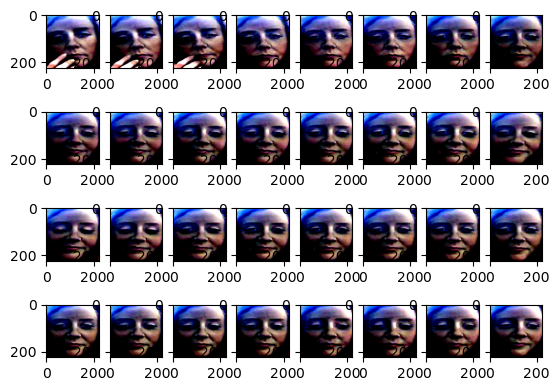

In [15]:
# Display images from the first chunk
fig, axs = plt.subplots(4, 8)
for i, ax in enumerate(axs.flatten()):
    ax.imshow(normalized_dataset[319, i])
plt.show()

In [10]:
import pandas as pd
import numpy as np

# extract the emotion values for videos 00000 to 00499
start_idx = 0
end_idx = 1001
labels = df.iloc[start_idx:end_idx+1, 2:9].to_numpy()

# print the shape of the emotions array
print(labels.shape)


(1002, 7)


In [11]:
import numpy as np
#590, 592 cannot detect face by RetinaFace
uncropped_videos = [590, 592]
labels = np.delete(labels, uncropped_videos, axis=0)
print(labels.shape)

(1000, 7)


In [12]:
print(labels[0])

[0.         0.03909015 1.         0.10674765 0.14294693 0.63313077
 0.30661064]


In [13]:
import numpy as np

total_samples = 1000

# Calculate number of samples for each set
train_samples = int(total_samples * 0.7)
valid_samples = int(total_samples * 0.15)
test_samples = total_samples - train_samples - valid_samples

# Split dataset and labels into train, validation, and test sets
train_dataset, train_labels = normalized_dataset[:train_samples], labels[:train_samples]
valid_dataset, valid_labels = normalized_dataset[train_samples:train_samples+valid_samples], labels[train_samples:train_samples+valid_samples]
test_dataset, test_labels = normalized_dataset[train_samples+valid_samples:], labels[train_samples+valid_samples:]

# Print shapes of each set
print("Train dataset shape:", train_dataset.shape)
print("Train labels shape:", train_labels.shape)
print("Valid dataset shape:", valid_dataset.shape)
print("Valid labels shape:", valid_labels.shape)
print("Test dataset shape:", test_dataset.shape)
print("Test labels shape:", test_labels.shape)


Train dataset shape: (700, 32, 224, 224, 3)
Train labels shape: (700, 7)
Valid dataset shape: (150, 32, 224, 224, 3)
Valid labels shape: (150, 7)
Test dataset shape: (150, 32, 224, 224, 3)
Test labels shape: (150, 7)


In [8]:
from tensorflow.keras.layers import ConvLSTM1D
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, MaxPool2D, concatenate, BatchNormalization, Dropout, AveragePooling2D
from tensorflow.keras.activations import relu, sigmoid, softmax
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import optimizers
from tensorflow.keras import models
#from keras_vggface.vggface import VGGFace
from tensorflow import keras
#Callback




early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=6,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    min_delta=0.0001,
    patience=3,
    verbose=0,
    mode='auto'
)

callbacks = [
    early_stopping,
    lr_scheduler,
]



In [9]:
import os
import ssl

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def video_data_generator(x_train, y_train, batch_size):
    # Create an ImageDataGenerator for data augmentation
    data_gen = ImageDataGenerator(
        brightness_range=[1, 1.5], # adjust the brightness
    )

    # Get the number of samples and steps per epoch
    num_samples = x_train.shape[0]
    steps_per_epoch = num_samples // batch_size

    while True:
        # Shuffle the data indices
        idx = np.random.permutation(num_samples)
        x_train = x_train[idx]
        y_train = y_train[idx]

        # Generate augmented data in batches
        for i in range(steps_per_epoch):
            batch_start = i * batch_size
            batch_end = (i + 1) * batch_size

            x_batch = x_train[batch_start:batch_end]
            y_batch = y_train[batch_start:batch_end]

            # Apply data augmentation to each frame
            for j in range(x_batch.shape[1]):
                augmented_frames = np.zeros_like(x_batch[:, j])
                for k, frame in enumerate(x_batch[:, j]):
                    augmented_frames[k] = data_gen.random_transform(frame)
                x_batch[:, j] = augmented_frames

            yield x_batch, y_batch






In [10]:
import numpy as np
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.metrics import Metric
from tensorflow.keras.callbacks import Callback
import tensorflow_probability as tfp

import tensorflow as tf
from tensorflow.keras.metrics import Metric
import numpy as np
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow import keras
import numpy as np
from scipy.stats import pearsonr

class CorrelationMetric(keras.metrics.Metric):
    def __init__(self, num_rows, name="correlation", **kwargs):
        super(CorrelationMetric, self).__init__(name=name, **kwargs)
        self.num_rows = num_rows
        self.correlations = self.add_weight(name="correlations", shape=(num_rows,), initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        for i in range(self.num_rows):
            true_row = y_true[i, :]
            pred_row = y_pred[i, :]

            n = tf.cast(tf.size(true_row), dtype=tf.float32)
            xy = tf.reduce_sum(tf.multiply(pred_row, true_row))
            x = tf.reduce_sum(pred_row)
            y = tf.reduce_sum(true_row)
            x_squared = tf.reduce_sum(tf.math.square(pred_row))
            y_squared = tf.reduce_sum(tf.math.square(true_row))

            correlation = (n * xy - x * y) / tf.math.sqrt((n * x_squared - tf.math.square(x)) * (n * y_squared - tf.math.square(y)))
            self.correlations[i].assign(correlation)

    def result(self):
        return tf.reduce_mean(self.correlations)

    def reset_state(self):
        self.correlations.assign(tf.zeros_like(self.correlations))


class CustomLogger(keras.callbacks.Callback):
    def __init__(self, correlation_metric):
        super(CustomLogger, self).__init__()
        self.correlation_metric = correlation_metric

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        avg_corr = self.correlation_metric.result().numpy()
        print("/n")
        print("Epoch {}: Average Pearson correlation coefficient: {:.3f}".format(epoch + 1, avg_corr))
        logs["correlation"] = avg_corr
        self.correlation_metric.reset_state()



correlation_metric = CorrelationMetric(7)
custom_logger = CustomLogger(correlation_metric)


2023-03-19 09:43:05.774051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38214 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0
2023-03-19 09:43:05.776180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38214 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:05.0, compute capability: 8.0
2023-03-19 09:43:05.778223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38214 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:06.0, compute capability: 8.0
2023-03-19 09:43:05.779831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38214 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [11]:
import ssl
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
# Visual part (frames)

# Visual part (frames)
ssl._create_default_https_context = ssl._create_unverified_context
frames_input = tf.keras.Input(shape=(32,224,224,3), name='Frames_Input')
resnet_layer = tf.keras.applications.ResNet50(weights="imagenet", include_top=False)
# Make training faster
resnet_layer.trainable = False
ssl._create_default_https_context = ssl.create_default_context
# Applies the same instance of Conv2D to each of the timestamps, the same set of weights are used at each timestamp.
conv_2d_layer = tf.keras.layers.TimeDistributed(resnet_layer)
visual_outputs = conv_2d_layer(frames_input)
global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
flattened_visual = tf.keras.layers.TimeDistributed(global_average_pooling)(visual_outputs)
lstm_layer = tf.keras.layers.LSTM(units=512, return_sequences=False)
lstm_outputs = lstm_layer(flattened_visual)
dense_visual = tf.keras.layers.Dense(units=64, name='dense_frames')(lstm_outputs)

# Define output
output_layer = Dense(units=7, activation='sigmoid', name='Output')(dense_visual)

model = Model(inputs=frames_input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse",metrics=correlation_metric)

In [20]:
# Create the generator with your train data and desired batch size
batch_size = 16
num_epochs = 20
num_samples = train_dataset.shape[0]
steps_per_epoch = num_samples // batch_size
# Prepare the generator for training data
train_generator = video_data_generator(train_dataset, train_labels, batch_size)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=(valid_dataset, valid_labels),
    validation_steps=len(valid_dataset) // batch_size,
    callbacks=[callbacks, custom_logger])



Epoch 1/20


2023-03-19 08:09:41.221283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-19 08:09:42.387229: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 1/43 [..............................] - ETA: 7:47 - loss: 0.1705 - correlation: -0.0281

2023-03-19 08:09:45.648235: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


43/43 [==============================] - 67s 1s/step - loss: 0.1507 - correlation: 0.4348 - val_loss: 0.1323 - val_correlation: 0.4348 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 46s 1s/step - loss: 0.1205 - correlation: 0.3153 - val_loss: 0.1168 - val_correlation: 0.3153 - lr: 0.0010
Epoch 3/20
43/43 [==============================] - 48s 1s/step - loss: 0.1124 - correlation: 0.3102 - val_loss: 0.1152 - val_correlation: 0.3102 - lr: 0.0010
Epoch 4/20
43/43 [==============================] - 48s 1s/step - loss: 0.1111 - correlation: 0.4052 - val_loss: 0.1155 - val_correlation: 0.4052 - lr: 0.0010
Epoch 5/20
43/43 [==============================] - 48s 1s/step - loss: 0.1117 - correlation: 0.4454 - val_loss: 0.1143 - val_correlation: 0.4454 - lr: 0.0010
Epoch 6/20
43/43 [==============================] - 48s 1s/step - loss: 0.1104 - correlation: 0.3356 - val_loss: 0.1145 - val_correlation: 0.3356 - lr: 0.0010
Epoch 7/20
43/43 [==============================] - 48s 1

In [25]:
from scipy.stats import pearsonr

correlations = []
for i in range(y_predict.shape[0]):
    corr, _ = pearsonr(y_predict[i, :], test_labels[i, :])
    correlations.append(corr)

avg_corr = np.mean(correlations)
print("Average Pearson correlation coefficient: {:.3f}".format(avg_corr))

Average Pearson correlation coefficient: 0.370


In [12]:
class CorrelationMetric(keras.metrics.Metric): 
    def __init__(self, name="correlation", **kwargs): 
        super(CorrelationMetric, self).__init__(name=name, **kwargs)
        self.correlation = self.add_weight(name="correlation", initializer="zeros")
        self.n = self.add_weight(name="n", initializer="zeros")
        self.x = self.add_weight(name="x", initializer="zeros")
        self.x_squared = self.add_weight(name="x_squared", initializer="zeros")
        self.y = self.add_weight(name="y", initializer="zeros")
        self.y_squared = self.add_weight(name="y_squared", initializer="zeros")
        self.xy = self.add_weight(name="xy", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None): 
        self.n.assign_add(tf.reduce_sum(tf.cast((y_pred == y_true), "float32")))
        self.n.assign_add(tf.reduce_sum(tf.cast((y_pred != y_true), "float32")))
        self.xy.assign_add(tf.reduce_sum(tf.multiply(y_pred, y_true)))
        self.x.assign_add(tf.reduce_sum(y_pred))
        self.y.assign_add(tf.reduce_sum(y_true))
        self.x_squared.assign_add(tf.reduce_sum(tf.math.square(y_pred)))
        self.y_squared.assign_add(tf.reduce_sum(tf.math.square(y_true)))
        
    def result(self): 
        return (self.n * self.xy - self.x * self.y)/tf.math.sqrt((self.n * self.x_squared - tf.math.square(self.x)) * (self.n * self.y_squared - tf.math.square(self.y)))
        
    def reset_state(self): 
        self.n.assign(0.0)
        self.x.assign(0.0)
        self.x_squared.assign(0.0)
        self.y.assign(0.0)
        self.y_squared.assign(0.0)
        self.xy.assign(0.0)
        self.correlation.assign(0.0)

In [36]:
# Set the GPU you want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Create a strategy for the specific GPU device
device = "/gpu:1"
strategy = tf.distribute.OneDeviceStrategy(device)

with strategy.scope():
    with tf.keras.utils.custom_object_scope({'CorrelationMetric': CorrelationMetric()}):
        model_predict = tf.keras.models.load_model('/home/yang/CVPR/Weights/my_model_resnet.h5')

    test_loss, test_metric = model_predict.evaluate(test_dataset, test_labels)
    print('Test Loss:', test_loss)
    print('Test Metric:', test_metric)

2023-03-19 09:09:38.350193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-19 09:09:39.200346: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


5/5 [==============================] - 17s 1s/step - loss: 0.1051 - correlation: 0.4167
Test Loss: 0.1050879955291748
Test Metric: 0.41672345995903015


In [37]:
y_predict = model.predict(test_dataset)

5/5 [==============================] - 4s 385ms/step


In [38]:
from scipy.stats import pearsonr

correlations = []
for i in range(y_predict.shape[0]):
    corr, _ = pearsonr(y_predict[i, :], test_labels[i, :])
    correlations.append(corr)

avg_corr = np.mean(correlations)
print("Average Pearson correlation coefficient: {:.3f}".format(avg_corr))

Average Pearson correlation coefficient: 0.408


In [40]:
#PREDICT on my_model_resnet 

In [13]:
# Set the GPU you want to use
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Create a strategy for the specific GPU device
device = "/gpu:2"
strategy = tf.distribute.OneDeviceStrategy(device)
with strategy.scope():
    with tf.keras.utils.custom_object_scope({'CorrelationMetric': CorrelationMetric()}):
        model_predict = tf.keras.models.load_model('/home/yang/CVPR/Weights/my_model_resnet.h5')


In [14]:
test_dataset = np.load('/home/yang/Test/test_dataset.npy')
print(test_dataset.shape)

(4604, 32, 224, 224, 3)


In [15]:
test_dataset.dtype

dtype('uint8')

In [16]:
prediction = model_predict.predict(test_dataset)

2023-03-19 09:45:29.784827: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-03-19 09:45:34.067217: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


  1/144 [..............................] - ETA: 44:07

2023-03-19 09:45:41.425558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


144/144 [==============================] - 76s 400ms/step


In [17]:
print(prediction.shape)

(4604, 7)


In [18]:
prediction

array([[0.08954428, 0.05703415, 0.13110323, ..., 0.19628899, 0.11842164,
        0.4925497 ],
       [0.12076977, 0.08836612, 0.1249247 , ..., 0.20201352, 0.15785916,
        0.3485458 ],
       [0.0597523 , 0.03913089, 0.34806454, ..., 0.1508227 , 0.26609144,
        0.42547166],
       ...,
       [0.06259517, 0.05599749, 0.2769085 , ..., 0.10130767, 0.25814128,
        0.3582657 ],
       [0.06119425, 0.08548059, 0.32971928, ..., 0.24047227, 0.15068226,
        0.68027264],
       [0.0433304 , 0.04154172, 0.19497123, ..., 0.2124122 , 0.30397397,
        0.48230577]], dtype=float32)

In [19]:
import pandas as pd
import numpy as np

# Remove rows with Split column equal to 'Train' or 'Val'
test_df = df[(df['Split'] == 'Test')]

# Extract the File_ID column as a NumPy array
file_ids = test_df['File_ID'].to_numpy()

# Apply preprocessing to the test dataset
test_data = test_df.drop(columns=['File_ID', 'Split', 'Age', 'Country']).to_numpy()
# apply the same preprocessing steps you used on the training dataset
# Combine the File_ID column and the predicted values into a new DataFrame
output_df = pd.DataFrame({'File_ID': file_ids, 'Adoration': prediction[:,0], 'Amusement': prediction[:,1], 
                          'Anxiety': prediction[:,2], 'Disgust': prediction[:,3], 
                          'Empathic-Pain': prediction[:,4], 'Fear': prediction[:,5], 
                          'Surprise': prediction[:,6]})

# Write the new DataFrame to a CSV file
output_df.to_csv('predictions.csv', columns=['File_ID', 'Adoration', 'Amusement', 'Anxiety', 'Disgust', 'Empathic-Pain', 'Fear', 'Surprise'], index=False)
